# Model NEATM + REFLECT MODEL @python3.8
$D_{eff}=\frac{1329\times10^{-H_v/5}}{\sqrt{p_v}}$
$p_v=\frac{A_B}{q}$
$q_s=\frac{F_{sun}}{d^2}$
$T_{fit}=[\frac{(1-A)F_{sun}}{\eta\epsilon\sigma d}]^{1/4}$
$T=T(\theta,\phi)=T_{fit}\cos^{1/4}\theta\cos^{1/4}\phi,(-\frac{\pi}{2}<\theta<\frac{\pi}{2},-\frac{\pi}{2}<\phi<\frac{\pi}{2})$
$F_\lambda=F(\Delta,d,\alpha|\eta,D)$

$F_\lambda=\frac{\epsilon D^2}{2\Delta ^2}\frac{\pi h c^2}{\lambda ^5}\int_{-\pi/2}^{\pi/2}d\phi\int_{\alpha-\pi/2}^{\pi/2}\frac{1}{exp(\frac{hc}{\lambda kT(\theta,\phi)}-1)}\cos^2 \phi\cos(\alpha-\theta)d\theta$

$F_\lambda=\frac{\epsilon D^2}{4\Delta ^2}\int_{-\pi/2}^{\pi/2}d\phi\int_{\alpha-\pi/2}^{\pi/2}\pi B(T,\lambda)\cos^2 \phi\cos(\alpha-\theta)d\theta$


# MCMC_NEATM

## define const & import

In [155]:
#import
import numpy as np
import matplotlib.pyplot as plt
import math as mh 
import pandas as pd
from tqdm import tqdm
import os
#constant
Fsun = 1367.5           # sun constant
sigma = 5.67E-8         #stefan-boltzmann constant
h = 6.626007015E-34     #plank constant
#q = 0.29+0.684*0.15    #phase integral = 0.29+0.684*G(=0.15)
epsi = 0.9              #radiance epsilon
kB = 1.38064852E-23     #boltzmann constant  j/k
cl = 299792458.0        #lightspeed m/s
au = 149597870700.0
pi = 3.1415926535
Rsun = 0.00465*au   #Rsun *m
Tsun = 5778         #Tsun  K
eta_guess = [1.2,0.7]
D_guess = [400,200000]
logf_guess = [1,0.1,1]
eta_piror = [0.5,2.8]
D_piror = [0,2500000]
Hv = 21.5
G = 0.15
Ndd = 15
lamdai = [12,22]

## define MODEL FUNCTION
initial x:flux = delta, it will change "delta"!
list: a,b
a = b
a = b[:]

### Model jhx

In [156]:
#constants---------------------------------------------------------------------------
#emissivity:
epsi = 0.9
#stefan-boltzman:
sigmas = 5.67*10**(-8)
#solar constant:
f_solar = 1367.5
#planck constant:
h = 6.62607015 * 10 ** (-34)
#speed of light
c = 3.0 * 10 ** 8 
#boltzmann constant
kb = 1.380649 * 10 ** (-23)
#astronomical unit in unit of meter
au = 1.496 * 10 ** 11
def neatm_jhx(Ndd,dast,dao,alpha,Dia,wlenth,yita,A):
    #dast: distance from asteroid to Sun :d
    #dobs: distance from observer to Sun  :dd
    #dao:  distance from asteroid to observer :delta
    #alpha: solar phase
    #dia: diameter of asteroid
    #wlenth: wavelength
    #yita: beaming parameter
    #A: bond albedo
	
	T_ss = ((1 - A) * f_solar / epsi / yita / sigmas / dast ** 2) ** 0.25
	Nd = int(Ndd)
	phi = np.zeros((Nd-1,1))
	theta = np.zeros((Nd-1,1))
	for i in range(0,Nd-1):#phi , theta is the angle from subsolar point
			phi[i] = -pi/2.0 + i * pi / Nd
			theta[i] = -pi/2.0 + i * pi / Nd
	nj = np.floor(((alpha - pi / 2.0) + pi / 2.0) / (pi / Nd)) 
	dphi, dtheta = pi/Nd,pi/Nd
	ss = dphi*dtheta#dtheta*dphi
	wlenth = wlenth * 10 ** (-6)
	temp = np.zeros((len(phi),len(theta)))
	flux = 0.0
	flux_con = epsi * Dia ** 2 * pi  * h * c ** 2  / (wlenth ** 5)
	for j in range(0,len(phi)):
		for k in range(int(nj),len(theta)):
			temp[j,k] = T_ss * np.cos(theta[k]) ** 0.25 * np.cos(phi[j]) ** 0.25
			flux = flux + flux_con * abs(np.cos(phi[j]) ** 2) * abs(np.cos(alpha - theta[k])) / (2 * (dao * au) ** 2) / (np.exp(h * c / (wlenth * kb * temp[j,k])) - 1) * ss * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy
	return flux
def Model_neatm_jhx(theta,x,lamda):
    eta,D =theta
    delta,d,alpha = x
    lamda1,lamda2 = lamda
    pv = (1329*pow(10,-Hv/5)/(D*0.001))**2
    q = 0.29+0.684*G
    A = q*pv
    nn = len(delta)
    flux = np.zeros(nn)
    for i in range(0,int(nn/2)):
        fluxi = neatm_jhx(Ndd,d[i],delta[i],alpha[i],D,lamda1,eta,A)
        if fluxi!=fluxi:fluxi = 0
        flux[i] = fluxi
    for i in range(int(nn/2),nn):
        fluxi = neatm_jhx(Ndd,d[i],delta[i],alpha[i],D,lamda2,eta,A)
        if fluxi!=fluxi:fluxi = 0
        flux[i] = fluxi
        
    #print('hello',flux)
    return flux

### Model hhq

In [181]:
def neatm_ohhq(Ndd,eta,D,delta,dd,alpha,lamda,A):   
    summ = 0.
    a = alpha-pi/2
    b = pi/2
    c = -pi/2          
    d = pi/2
    Tfit = np.power((1-A)*Fsun/(eta*epsi*sigma*dd*dd),0.25)
    #print(f"Tss = {Tfit-273}\n")
    dxdy = ((b-a)*(d-c)/(Ndd*Ndd)) 
    for j in range(Ndd):
        for i in range(Ndd):
            phii = (c+(d-c)*j/Ndd)
            thei = (a+(b-a)*i/Ndd)
            T = Tfit*np.power(np.cos(thei),0.25)*np.power(np.cos(phii),0.25)
            integral = np.cos(phii)**2*np.cos(alpha-thei)/(np.exp(h*cl/(lamda*kB*T))-1)
            summ = summ + dxdy*integral
    F = (epsi*np.power(D,2)*pi*h*cl*cl)*summ/(2*np.power(delta*au,2)*np.power(lamda,5))
    F = F*(lamda)**2/cl*1e29
    return F
def Model_neatm_ohhq(theta,x,lamda):
    eta,D = theta
    delta,d,alpha = x
    lamda1,lamda2 = lamda
    pv = (1329*pow(10,-Hv/5)/(D*0.001))**2
    q = 0.29+0.684*G
    A = q*pv
    #initial flux
    flux = np.zeros(len(delta))
    nn = int(len(flux))
    for i in range(0,(int(nn/2))-1):
        flux[i] = neatm_ohhq(Ndd,eta,D,delta[i],d[i],alpha[i],lamda1*1e-6,A)
    for i in range(int(nn/2),nn):
        flux[i] = neatm_ohhq(Ndd,eta,D,delta[i],d[i],alpha[i],lamda2*1e-6,A)
    return flux

### Model reflect

#### cal $H(\alpha)$

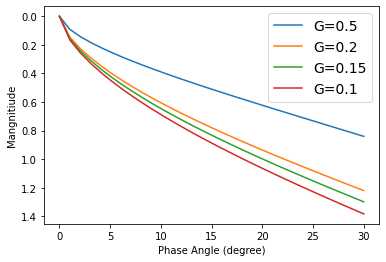

In [158]:
A1,A2 = 3.332,1.862
B1,B2 = 0.631,1.218
C1,C2 = 0.986,0.238
def calW(alpha):
    return np.exp(-90.56*np.tan(alpha/2)**2)
def calphiiS(i,alpha):
    Ci = C1
    if i == 2 :
        Ci = C2
    aa = 0.119+1.341*np.sin(alpha)-0.754*np.sin(alpha)**2
    return 1-Ci*np.sin(alpha)/aa
def calphiiL(i,alpha):
    Ai = A1
    Bi = B1
    if i == 2 :
        Ai = A2
        Bi = B2
    return np.exp(-Ai*np.tan(alpha/2)**Bi)
def calphii(i,alpha):
    W = calW(alpha)
    return W*calphiiS(i,alpha)+(1-W)*calphiiL(i,alpha)
def calHalpha(alpha,G,H):
    aa = (1-G)*calphii(1,alpha)+G*calphii(2,alpha)
    return H - 2.5*np.log10(aa)
def calpromixHalpha(alpha,G,H):
    aa = (1-G)*calphiiL(1,alpha)+G*calphiiL(2,alpha)
    return H - 2.5*np.log10(aa)
#plot 
alpha_degree = np.linspace(0,30,30)
alpha = alpha_degree/180*np.pi
ax = plt.gca()
ax.invert_yaxis()
plt.plot(alpha_degree,calpromixHalpha(alpha,0.5,0),label = 'G=0.5')
plt.plot(alpha_degree,calpromixHalpha(alpha,0.2,0),label = 'G=0.2')
plt.plot(alpha_degree,calpromixHalpha(alpha,0.15,0),label = 'G=0.15')
plt.plot(alpha_degree,calpromixHalpha(alpha,0.1,0),label = 'G=0.1')
plt.legend(fontsize=14)
plt.xlabel("Phase Angle (degree)")
plt.ylabel("Mangnitiude");

#### cal  $F_v^{ref}(\lambda)$

$F_v^{ref}(\lambda) = (\frac{D}{2\Delta})^2 \frac{\Psi(\alpha,G)}{q(G)}[1-\epsilon(\lambda)]F_v^{\odot}$

$F_v^{\odot}=(\frac{R_{\odot}}{r})^2\pi B_v(T_{\odot},\lambda), T_{\odot} = 5,778K, R_{\odot} = 0.00465AU$

$B_v(T_{\odot},\lambda) = \frac{8\pi hc}{\lambda ^5} \cdot \frac{1}{\exp(\frac{hc}{\lambda k_B T})-1}$

In [193]:
qG = 0.29+0.684*G
#def calPlank(T,lamda):
#    aa = np.exp(h*cl/(lamda*kB*T))-1
#    return 8*pi*h*cl/(lamda**5)/aa
# papper ATM
def calcPlanckLambda(lambd, T):
    return np.where(
        (lambd <= 0.0) | (T <= 0.0),
        0.0,
        (2*h*cl**2)/lambd**5 * 1/(np.exp((h*cl)/(lambd*kB*T)) - 1)
        )
def calFsun(lamda,d):
    #print(f'sunconst={(Rsun/(d*au))**2*pi},planksun = {calcPlanckLambda(Tsun,lamda)}')
    #return (Rsun/(d*au))**2*pi*calcPlanckLambda(Tsun,lamda)
    return (Rsun/(d*au))**2*pi*calcPlanckLambda(lamda,Tsun)
def calFref(D,delta,d,alpha,lamda,epsiLamda):
    cons = (0.5*D/(delta*au))**2*(1-epsiLamda)/qG
    Fref = cons*calpromixHalpha(alpha,G,Hv)*calFsun(lamda,d)
    #print(f'hg = {calpromixHalpha(alpha,G,Hv)},cons = {cons},fsun ={calFsun(lamda,d)},lamda = {(lamda)**2/cl*1e29} ')
    return Fref*(lamda)**2/cl*1e29
print(f'G = {G}, Hv = {Hv}')

G = 0.15, Hv = 21.5


##### test plank

/tmp/ipykernel_298786/2758682263.py:10: RuntimeWarning: divide by zero encountered in true_divide
  (2*h*cl**2)/lambd**5 * 1/(np.exp((h*cl)/(lambd*kB*T)) - 1)
/tmp/ipykernel_298786/2758682263.py:10: RuntimeWarning: invalid value encountered in true_divide
  (2*h*cl**2)/lambd**5 * 1/(np.exp((h*cl)/(lambd*kB*T)) - 1)
/tmp/ipykernel_298786/2758682263.py:10: RuntimeWarning: divide by zero encountered in true_divide
  (2*h*cl**2)/lambd**5 * 1/(np.exp((h*cl)/(lambd*kB*T)) - 1)


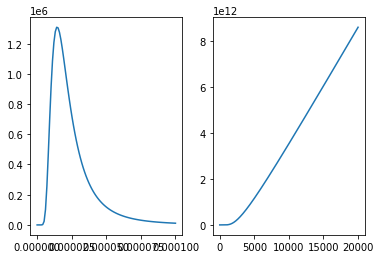

In [145]:
lamdaa = np.linspace(0,100e-6,100)
pl1 = calcPlanckLambda(lamdaa,200)
plt.subplot(1,2,1)
plt.plot(lamdaa,pl1)
Ttt = np.linspace(0,20000,1000)
pl2 = calcPlanckLambda(2e-6,Ttt)
plt.subplot(1,2,2)
plt.plot(Ttt,pl2)

### model atm

In [146]:
## test
def bandpassLambda(F, args=[]):
        """
        Computes the WISE bandpass throughput for any arbitrary function of wavelength.
        For more details, see: http://adsabs.harvard.edu/abs/2013AAS...22143905W

        Parameters
        ----------
        F : function
            Any function whose first argument is lambda in meters.
        args : list
            List of arguments to pass to the function F.

        Returns
        -------
        `~numpy.ndarray` (N, 4)
            The throughput for each filter.
        """
        return np.array([
            0.5117*F(3.0974e-6, *args) + 0.4795*F(3.6298e-6, *args),
            0.5811*F(4.3371e-6, *args) + 0.4104*F(4.9871e-6, *args),
            #0.1785*F(8.0145e-6, *args) + 0.4920*F(11.495e-6, *args) + 0.2455*F(15.256e-6, *args),   # Wright
            0.1414*F(8.6109e-6, *args) + 0.4412*F(11.786e-6, *args) + 0.4174*F(15.277e-6, *args),   # NM 
            0.7156*F(21.150e-6, *args) + 0.2753*F(24.690e-6, *args)])
def calcFluxLambdaSun(lambd, r, T=Tsun):
    return (np.pi * Rsun**2) / (r**2 * au**2) * calcPlanckLambda(lambd, T)

def calcFluxLambdaAtObsWithSunlight(r, delta, lambd, D, alpha, p, G,H):
    """
    Calculate the flux at an observer or observatory from an asteroid with
    reflected sunlight.

    Parameters
    ----------
    model : `~atm.models.Model`
        Flux model object.
    r : float or `~numpy.ndarray` (N)
        Distance between asteroid and the Sun in AU.
    delta : float or `~numpy.ndarray` (N)
        Distance between asteroid and the observatory in AU.
    lambd : float or `~numpy.ndarray` (N)
        Wavelength in m.
    T_ss : float or `~numpy.ndarray` (N)
        Subsolar temperature in K.
    D : float or `~numpy.ndarray` (N)
        Asteroid diameter in meters.
    alpha : float or `~numpy.ndarray` (N)
        Phase angle in radians.
    eps : float or `~numpy.ndarray` (N)
        Emissivity.
    p : float or `~numpy.ndarray` (N)
        Albedo.(calcFluxLambdaAtObs(model, r, delta, lambd, T_ss, D, alpha, eps, threads=threads) 
            + 
    G : float or `~numpy.ndarray` (N)
        HG slope parameter.
    threads : int, optional
        Number of processors to use.
        [Default = `atm.Config.threads`]

    Returns
    -------
    float or `~numpy.ndarray` (N)
        Returns array of fluxes at an observer or observatory with
        reflected sunlight.
    """
    return (D**2 / (4 * delta**2 * au**2)) * p * calHalpha(alpha, G,H)*bandpassLambda(calcFluxLambdaSun,args=[r])

## read data file

#### 处理原始数据 将坐标垂直叠加，方便直接计算12，22微米的流量

In [147]:
namelist = ['2003MA3','2010CO1','2010DG77','2010EX11','2010FC81','2010FH81','2010GS7','2010JN71','2010KX7','2010PW58','2010XP69','2019DD2']
name = '2010co1'

#### read data & cal  
$x\equiv \Delta,d,\alpha$

In [170]:
obsec = np.loadtxt(f'newepoch_{name}.txt')
name = namelist[1].lower()
obsec = np.loadtxt(f'newepoch_{name}.txt')
obsdat12 = np.loadtxt(f'w12_{name}.txt')
obsdat34 = np.loadtxt(f'w34_{name}.txt')
#ast-sun
d_N = np.sqrt(obsec[:,0]**2+obsec[:,1]**2+obsec[:,2]**2)
#print('ast-sun',d_N)
#ast-earth
delta_N = np.sqrt((obsec[:,3]-obsec[:,0])**2+(obsec[:,4]-obsec[:,1])**2+(obsec[:,5]-obsec[:,2])**2)
#print('ast-earth',delta_N)
#earth-sun
dd_N = np.sqrt(obsec[:,3]**2+obsec[:,4]**2+obsec[:,5]**2)
#print('earth-sun',dd_N)
#alpha
alpha_N = (delta_N*delta_N+d_N*d_N-dd_N*dd_N)/(2*delta_N*d_N)
alpha_N = np.arccos(alpha_N)
#print("alpha",alpha_N/pi*180,'\n')
x = (delta_N,d_N,alpha_N)

#### cal Flex


64


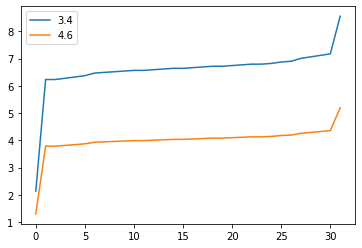

In [204]:
y0 = obsdat12
print(len(y0))
fluxRef1 = calFref(346,delta_N[0:32],d_N[0:32],alpha_N[0:32],3.4e-6,epsi)
fluxRef2 = calFref(346,delta_N[32:64],d_N[32:64],alpha_N[32:64],4.6e-6,epsi)
fluxRefATM = calcFluxLambdaAtObsWithSunlight(d_N, delta_N, 1.2e-6, 346, alpha_N, 0.9, G,Hv)
#print(fluxRef)
#print(fluxRefATM)
plt.plot(fluxRef1,label='3.4')
plt.plot(fluxRef2,label='4.6')
plt.legend()

cal Flux in W1/W2

/tmp/ipykernel_298786/3361495899.py:15: RuntimeWarning: overflow encountered in exp
  integral = np.cos(phii)**2*np.cos(alpha-thei)/(np.exp(h*cl/(lamda*kB*T))-1)


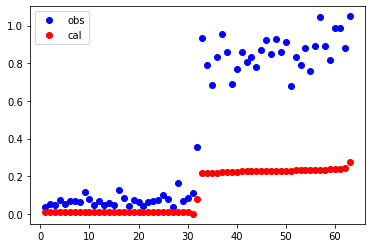

In [186]:
y = obsdat12
nt = np.arange(len(d_N))
theta = [3.4,346]
flux = Model_neatm_ohhq(theta,x=(delta_N,d_N,alpha_N),lamda=[3.4,4.6])
yerr = 0.1*y
#print(flux)
plt.plot(nt[1:len(y)],obsdat12[1:len(y)],'bo',label = 'obs')
plt.plot(nt[1:len(y)],flux[1:len(y)],'ro',label = 'cal')
plt.legend() 

#### cal Flux in W3\W4

/tmp/ipykernel_298786/3361495899.py:15: RuntimeWarning: overflow encountered in exp
  integral = np.cos(phii)**2*np.cos(alpha-thei)/(np.exp(h*cl/(lamda*kB*T))-1)


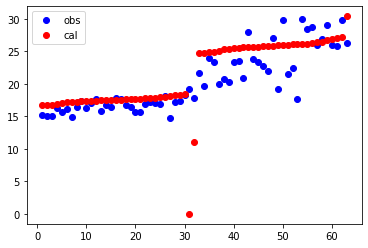

In [183]:
y = obsdat34
nt = np.arange(len(d_N))
theta = [3.4,346]
flux = Model_neatm_ohhq(theta,x=(delta_N,d_N,alpha_N),lamda=lamdai)
yerr = 0.1*y
#print(flux)
plt.plot(nt[1:len(y)],obsdat34[1:len(y)],'bo',label = 'obs')
plt.plot(nt[1:len(y)],flux[1:len(y)],'ro',label = 'cal')
plt.legend() 


## define MCMC_function

In [10]:
#initial
eta_gs = 1.2
D_gs = 150
eta_gss = [0.5,5]
D_gss = [1,500]

In [11]:
#MCMC Function
def log_likelihood(theta, x, y, yerr):
    eta,D= theta
    model = Model_neatm_ohhq(theta,x,lamdai)
    #model = eta*x[0]*100 + D
    sigma2 = yerr ** 2
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))
def log_prior(theta):
    eta,D = theta
    if eta_gss[0]< eta < eta_gss[1] and D_gss[0] < D < D_gss[1]:
        return 0.0
    return -np.inf
    #return 0
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
     #   print('hi','-inf')
        return -np.inf
    yy=lp + log_likelihood(theta, x, y, yerr)
    #print('hi',yy)
    return yy


In [12]:
#initial para guesses
eta = eta_gs
D = D_gs
theta = [eta, D]

In [13]:
import emcee
#initialize sampler
ndim, nwalkers = len(theta), 10
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr))
pos = [theta + 1e-6*np.random.randn(ndim) for i in range(nwalkers)]
#run mcmc
sampler.run_mcmc(pos, 1000, progress=True);

/tmp/ipykernel_4437/1970839062.py:16: RuntimeWarning: overflow encountered in exp
  integral = np.cos(phii)**2*np.cos(alpha-thei)/(np.exp(h*cl/(lamda*kB*T))-1)
100%|██████████| 1000/1000 [16:54<00:00,  1.01s/it]


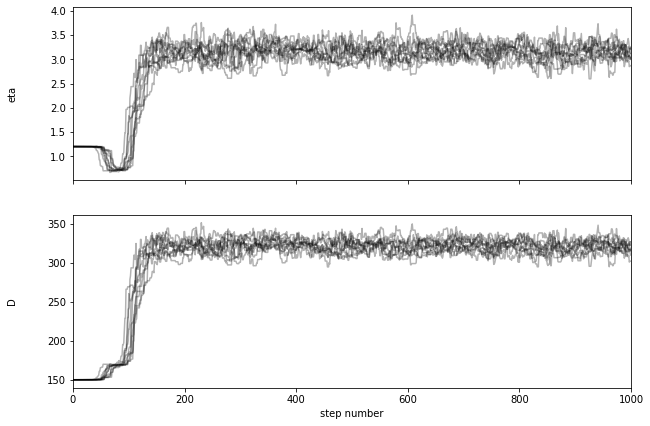

In [14]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["eta", "D"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    axes[-1].set_xlabel("step number");

(260, 2)


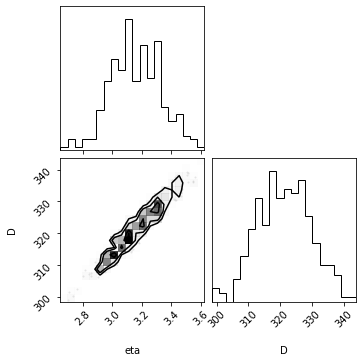

In [15]:
#--------------------------
flat_samples = sampler.get_chain(discard=600, thin=15, flat=True)
print(flat_samples.shape)
import corner
fig = corner.corner(
flat_samples, labels=labels, truths=[eta_gs, 103816]
);

In [16]:
from IPython.display import display, Math
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    #print(mcmc[1],q[0],q[1],labels[i])
    display(Math(txt))
print(Math(txt))
D_low,D_fit,D_high = np.percentile(flat_samples[:, 1], [16, 50, 84])
pv = (1329*pow(10,-Hv/5)/(D_fit*0.001))**2
print('eta_gs = ',eta_gs,'D_gs= ',D_gs,'pv=',pv)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>
eta_gs =  1.2 D_gs=  150 pv= 0.04295869088296023


In [24]:
def loss(obs,cal,err):
    l = len(obs)
    return sum(((obs-cal)/err)**2)/l
print('LossFunction = ',loss(y,Model_neatm_ohhq(theta,x,lamdai),yerr))

LossFunction =  2.844128982176855


/tmp/ipykernel_4437/1970839062.py:16: RuntimeWarning: overflow encountered in exp
  integral = np.cos(phii)**2*np.cos(alpha-thei)/(np.exp(h*cl/(lamda*kB*T))-1)


In [18]:
print('LossFunction = ',loss(y,Model_neatm_jhx(theta,x,lamdai),yerr))

LossFunction =  32.33653113937658


/tmp/ipykernel_4437/4018011249.py:43: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * abs(np.cos(phi[j]) ** 2) * abs(np.cos(alpha - theta[k])) / (2 * (dao * au) ** 2) / (np.exp(h * c / (wlenth * kb * temp[j,k])) - 1) * ss * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy


## read time

In [19]:
import pandas as pd
rawdata = pd.read_csv(f'time_{name}.txt')
timelist = rawdata['mjd'].tolist()
timelist

[55203.276312,
 55227.560587,
 55227.560715,
 55227.693019,
 55227.825323,
 55227.957628,
 55228.222364,
 55228.288579,
 55228.354668,
 55228.420884,
 55228.486972,
 55228.487099,
 55228.553188,
 55228.619404,
 55228.685492,
 55228.685619,
 55228.751708,
 55228.817924,
 55228.884012,
 55228.88414,
 55228.950228,
 55229.016444,
 55229.082532,
 55229.08266,
 55229.148748,
 55229.281052,
 55229.347268,
 55229.612004,
 55229.744309,
 55229.876613,
 55230.009044,
 55232.92062]

eta_fit =  3.14906293678208 D_fit=  321.3656556186102 pv =  0.04295869088296023
loss =  inf


/tmp/ipykernel_4437/1970839062.py:16: RuntimeWarning: overflow encountered in exp
  integral = np.cos(phii)**2*np.cos(alpha-thei)/(np.exp(h*cl/(lamda*kB*T))-1)
/tmp/ipykernel_4437/2581898002.py:7: RuntimeWarning: divide by zero encountered in true_divide
  return sum(((cal-y)/yerr)**2)/nn
/tmp/ipykernel_4437/1970839062.py:16: RuntimeWarning: overflow encountered in exp
  integral = np.cos(phii)**2*np.cos(alpha-thei)/(np.exp(h*cl/(lamda*kB*T))-1)
/tmp/ipykernel_4437/1970839062.py:16: RuntimeWarning: overflow encountered in exp
  integral = np.cos(phii)**2*np.cos(alpha-thei)/(np.exp(h*cl/(lamda*kB*T))-1)
/tmp/ipykernel_4437/1970839062.py:16: RuntimeWarning: overflow encountered in exp
  integral = np.cos(phii)**2*np.cos(alpha-thei)/(np.exp(h*cl/(lamda*kB*T))-1)
/tmp/ipykernel_4437/1970839062.py:16: RuntimeWarning: overflow encountered in exp
  integral = np.cos(phii)**2*np.cos(alpha-thei)/(np.exp(h*cl/(lamda*kB*T))-1)
/tmp/ipykernel_4437/1970839062.py:16: RuntimeWarning: overflow encount

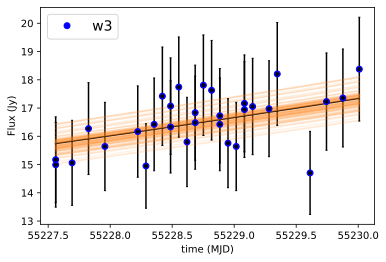

In [23]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
def loss(cal,y,yerr):
    nn = len(y)
    return sum(((cal-y)/yerr)**2)/nn
eta_low,eta_fit,eta_high = np.percentile(flat_samples[:, 0], [16, 50, 84])
D_low,D_fit,D_high = np.percentile(flat_samples[:, 1], [16, 50, 84])
print('eta_fit = ',eta_fit,'D_fit= ',D_fit,'pv = ',(1329*pow(10,-Hv/5)/(D_fit*0.001))**2)
theta = eta_fit,D_fit

leni = len(nt)
half = int(leni/2)
yt = Model_neatm_ohhq(theta,x,lamdai)
print('loss = ',loss(yt,y,yt*0.1))
plt.plot(timelist[1:half-1], yt[1:half-1],"k")

inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    #print(ind,':',sample)
    plotmodel = Model_neatm_ohhq(sample,x,lamdai)
    plt.plot(timelist[1:half-1], plotmodel[1:half-1], "C1", alpha=0.1)
plt.plot(timelist[1:half-1],y[1:half-1],'bo',label = 'w3')
plt.errorbar(timelist[1:half-1], y[1:half-1], yerr=yerr[1:half-1], fmt=".k", capsize=1.0)
plt.legend(fontsize=14)
plt.xlabel("time (MJD)")
plt.ylabel("Flux (Jy)");
plt.savefig(f'{name}_w3.pdf')

## 0.382,0.410

/tmp/ipykernel_4437/1970839062.py:16: RuntimeWarning: overflow encountered in exp
  integral = np.cos(phii)**2*np.cos(alpha-thei)/(np.exp(h*cl/(lamda*kB*T))-1)
/tmp/ipykernel_4437/1970839062.py:16: RuntimeWarning: overflow encountered in exp
  integral = np.cos(phii)**2*np.cos(alpha-thei)/(np.exp(h*cl/(lamda*kB*T))-1)
/tmp/ipykernel_4437/1970839062.py:16: RuntimeWarning: overflow encountered in exp
  integral = np.cos(phii)**2*np.cos(alpha-thei)/(np.exp(h*cl/(lamda*kB*T))-1)
/tmp/ipykernel_4437/1970839062.py:16: RuntimeWarning: overflow encountered in exp
  integral = np.cos(phii)**2*np.cos(alpha-thei)/(np.exp(h*cl/(lamda*kB*T))-1)
/tmp/ipykernel_4437/1970839062.py:16: RuntimeWarning: overflow encountered in exp
  integral = np.cos(phii)**2*np.cos(alpha-thei)/(np.exp(h*cl/(lamda*kB*T))-1)
/tmp/ipykernel_4437/1970839062.py:16: RuntimeWarning: overflow encountered in exp
  integral = np.cos(phii)**2*np.cos(alpha-thei)/(np.exp(h*cl/(lamda*kB*T))-1)
/tmp/ipykernel_4437/1970839062.py:16: Ru

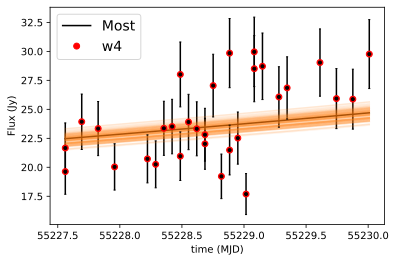

In [26]:
plt.plot(timelist[1:half-1], yt[half+1:leni-1],"k", label="Most")

inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    #print(ind,':',sample)
    plotmodel = Model_neatm_ohhq(sample,x,lamdai)
    plt.plot(timelist[1:half-1], plotmodel[half+1:leni-1], "C1", alpha=0.1)
plt.plot(timelist[1:half-1],y[half+1:leni-1],'ro',label = 'w4')
plt.errorbar(timelist[1:half-1], y[half+1:leni-1], yerr=yerr[half+1:leni-1], fmt=".k", capsize=1.0)
plt.legend(fontsize=14)
plt.xlabel("time (MJD)")
plt.ylabel("Flux (Jy)");
plt.savefig(f'{name}_w4.svg')


/tmp/ipykernel_4437/1970839062.py:16: RuntimeWarning: overflow encountered in exp
  integral = np.cos(phii)**2*np.cos(alpha-thei)/(np.exp(h*cl/(lamda*kB*T))-1)
/tmp/ipykernel_4437/1970839062.py:16: RuntimeWarning: overflow encountered in exp
  integral = np.cos(phii)**2*np.cos(alpha-thei)/(np.exp(h*cl/(lamda*kB*T))-1)
/tmp/ipykernel_4437/1970839062.py:16: RuntimeWarning: overflow encountered in exp
  integral = np.cos(phii)**2*np.cos(alpha-thei)/(np.exp(h*cl/(lamda*kB*T))-1)
/tmp/ipykernel_4437/1970839062.py:16: RuntimeWarning: overflow encountered in exp
  integral = np.cos(phii)**2*np.cos(alpha-thei)/(np.exp(h*cl/(lamda*kB*T))-1)
/tmp/ipykernel_4437/1970839062.py:16: RuntimeWarning: overflow encountered in exp
  integral = np.cos(phii)**2*np.cos(alpha-thei)/(np.exp(h*cl/(lamda*kB*T))-1)
/tmp/ipykernel_4437/1970839062.py:16: RuntimeWarning: overflow encountered in exp
  integral = np.cos(phii)**2*np.cos(alpha-thei)/(np.exp(h*cl/(lamda*kB*T))-1)
/tmp/ipykernel_4437/1970839062.py:16: Ru

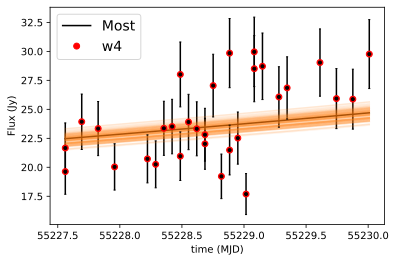

In [ ]:
plt.plot(timelist[1:half-1], yt[half+1:leni-1],"k", label="Most")

inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    #print(ind,':',sample)
    plotmodel = Model_neatm_ohhq(sample,x,lamdai)
    plt.plot(timelist[1:half-1], plotmodel[half+1:leni-1], "C1", alpha=0.1)
plt.plot(timelist[1:half-1],y[half+1:leni-1],'ro',label = 'w4')
plt.errorbar(timelist[1:half-1], y[half+1:leni-1], yerr=yerr[half+1:leni-1], fmt=".k", capsize=1.0)
plt.legend(fontsize=14)
plt.xlabel("time (MJD)")
plt.ylabel("Flux (Jy)");
plt.savefig(f'{name}_w4.svg')
